# Twitter Job Hunter Modelling Notebook
by A4Ayub Hands-On Labs (http://www.a4ayub.me)

## Background Information

On 15th July 2020 we , A4Ayub Hands-On Labd started a new Hands-On Project Based Learning path dubbed  **build a twitter job hunting chatbot** after successful registration of the below participants:


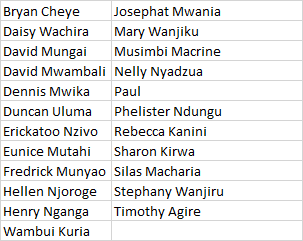

## The Data

**On Day #1**, we learnt about how to scrap data from twitter and everyone was tasked to practice and scrape job related tweets from twitter as a contribution to the crowdsourced data as we learn and we collectively generated the dataset that is to be used to model the chatbot responses. 

We collected approximately 29,000 job related tweets from twitter. Thanks to the contribution of the participants.

**On Day #2**, we will cover data cleaning. We shall learn data cleaning and wrangling techniques as a way of preparing the data for visualisation and this notebook will be updated with what each person will have learnt in class.

In [9]:
# Import the required libraries
from __future__ import division, print_function
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings

import string

from nltk.corpus import stopwords
from nltk import word_tokenize

from wordcloud import WordCloud,STOPWORDS

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=DeprecationWarning)

import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='./logs/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split

import pickle
import gensim
from gensim import models
from gensim.models import word2vec
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim
import spacy

%matplotlib inline

In [10]:
# import the data
twitter_df = pd.read_csv("./datasets/twitter-job-hunter-dataset.csv",engine="python", parse_dates=True, index_col=0);

In [11]:
# check for the datatypes
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6104 entries, 2020-06-25 09:39:04+00:00 to 2020-06-27 05:03:00
Data columns (total 9 columns):
Text               6104 non-null object
Source             6064 non-null object
harsh tag          1017 non-null object
Favourite Count    5914 non-null float64
Retweets           5583 non-null float64
6                  4939 non-null float64
7                  4939 non-null float64
submitter_name     6104 non-null object
industry           6104 non-null object
dtypes: float64(4), object(5)
memory usage: 476.9+ KB


In [12]:
twitter_df.sample(5)

,Text,Source,harsh tag,Favourite Count,Retweets,6,7,submitter_name,industry
ï»¿Datetime,,,,,,,,,
2020-07-16 03:45:01+00:00,"New #remote #job Software Engineer, Codespaces...",WantRemoteJob,NaN,1.0,0.0,0.0,0.0,Eric Nzivo,Software Developers
2020-06-29 22:04:00,Looking for more job opportunities? Check out ...,KaziQuest,0,0.0,NaN,NaN,NaN,Kennedy Njoroge,Management Job
2020-07-12 17:10:03+00:00,Support Worker #Maidstone #VACANCY We are look...,Choice_Support,NaN,0.0,0.0,0.0,0.0,Eric Nzivo,Health
2020-07-13 12:02:50+00:00,Store Manager #vacancy with @IcelandFoods base...,JCPinNorthScot,NaN,0.0,2.0,0.0,0.0,Eric Nzivo,Management Job
2020-07-16 23:09:00,.@CulverCityGov is #hiring a HUMAN RESOURCES A...,AgoraPulse Manager,NaN,1.0,3.0,NaN,NaN,David Mwambali,Management Job


In [13]:
# check for any null values
twitter_df.isnull().values.any()

True

In [14]:
# Check for null values in the text column
twitter_df["Text"].isnull().values.any()

False

In [15]:
# Check for null values in the text column
twitter_df["Source"].isnull().values.any()

True

In [16]:
# Only consider the tweets that the source is not null
twitter_df = twitter_df[~twitter_df["Source"].isnull()]
twitter_df["Source"].isnull().values.any()

False

In [17]:
# derive a new dtaframe having the fields that we require
twitter_df = twitter_df[["Text","Source","industry"]]
twitter_df.sample(5)

,Text,Source,industry
ï»¿Datetime,,,
2020-06-23 15:29:20+00:00,We're #hiring! #ServiceNow is looking for Seni...,WouterReefman,Management Job
2020-07-14 07:00:35+00:00,New post: Job Opening at Kenya Wine Agencies L...,CareerpointSolu,Management Job
2020-06-24 11:42:50+00:00,We have a #vacancy for a Trainee Catering Rati...,trinityhouse_uk,Trainee Job
2020-07-06 05:01:00+00:00,"JOB | Project Manager, Value Chains and Financ...",Finance_501,Management Job
2020-07-09 09:07:55+00:00,This post on @LinkedIn where the hiring manage...,SimsMbugua,Management Job


### Some cleaning requirements

1. Get rid of punctuations, numbers and even special characters
2. stop words
3. tokenization
4. stemming

### Custom functions

In [18]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]   

In [19]:
def removeStopWords(tokens): 
    stoplist = stopwords.words('english')
    return [word for word in tokens if word not in stoplist]

In [20]:
# Perform Data Cleaning on the text
def cleaning(message):
    import nltk
    
    # 1. Remove HTML.
    html_text = BeautifulSoup(message,"html.parser").get_text()
               
    # 2. Convert to lower case.
    letters = html_text.lower()  
    
    # 3. Remove non-letters.
    letters = re.sub("[^a-zA-Z]", " ", html_text)    
    letters = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', html_text)
    letters = re.sub(' +',' ', html_text)
    letters = re.sub('#','', html_text)
    letters = re.sub(r'[^\x00-\x7F]+',' ', html_text)
    letters = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",html_text)
    letters = re.sub(r"\n", " ", letters)    
    letters = re.sub(r"\r", " ", letters) 
    #letters = re.sub(r"[0-9]", "", letters)
    letters = re.sub(r"\'", " ", letters)    
    letters = re.sub(r"\"", " ", letters)
    
    # 4. Tokenize.
    tokens = nltk.word_tokenize(letters)
    
    # 5. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 6. Remove stop words. 
    words = [w for w in tokens if not w in stops]
    
    # 7. Stemming
    words = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]
    
    # 8. Join the words back into one string separated by space, and return the result.
    return " ".join(tokens)

In [21]:
# Create a word cloud
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [22]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

### Some Questions

1. Common words in the entire dataset
2. Frequency of Source
3. Common words by Source
4. How many hash tags are there in a tweet
5. What are the general trends
6. Which trendscan we observe per source

In [23]:
# apply the cleaning function
twitter_df["clean_tweet"] = twitter_df['Text'].apply(cleaning)

In [24]:
# tokenize
twitter_df["tokens"] = [word_tokenize(sen) for sen in twitter_df.clean_tweet]

In [25]:
# lowercase
twitter_df["tokens"] = [lower_token(token) for token in twitter_df.tokens]

In [26]:
# remove stop words
twitter_df["tokens"] = [removeStopWords(sen) for sen in twitter_df.tokens]

In [27]:
# encode industry
twitter_df['industry_id'], industry_mappings_by_id = twitter_df['industry'].factorize() 

In [28]:
# sample the twitter_df
pd.options.display.max_colwidth = 1000
twitter_df.sample(5)

,Text,Source,industry,clean_tweet,tokens,industry_id
ï»¿Datetime,,,,,,
2020-07-02 10:07:45+00:00,We are now looking for a part-time graphic designer. Join our enthusiastic marketing team! Check the full job description and apply here: https://bit.ly/38ix5jB #delmic #job #graphicdesigner #vacancy,delmicbv,Sales Executive Job,We are now looking for a part time graphic designer Join our enthusiastic marketing team Check the full job description and apply here delmic job graphicdesigner vacancy,"[looking, part, time, graphic, designer, join, enthusiastic, marketing, team, check, full, job, description, apply, delmic, job, graphicdesigner, vacancy]",13
2020-07-03 05:03:00+00:00,"JOB | Business Transformation Manager | @WFP | Nairobi, Kenya | NGO | Mid Level | Degree in Finance, Business Administration, Economics, Computer Sciences or related field | Closing 24 July 2020 | https://bit.ly/31Dy3pb #IkoKaziKE #IkoKazi",Finance_501,Management Job,JOB Business Transformation Manager Nairobi Kenya NGO Mid Level Degree in Finance Business Administration Economics Computer Sciences or related field Closing 24 July 2020 IkoKaziKE IkoKazi,"[job, business, transformation, manager, nairobi, kenya, ngo, mid, level, degree, finance, business, administration, economics, computer, sciences, related, field, closing, 24, july, 2020, ikokazike, ikokazi]",12
2020-07-15 22:01:37+00:00,Looking for more job opportunities? Check out the Project Officer-Mental at HealthRight International Job Click here to apply http://app.kaziquest.com/jobs/project-officer-mental-at-healthright-international/ #IkoKaziKE #IkoKazi #Hiring #JobOpening,KaziQuest,Health,Looking for more job opportunities Check out the Project Officer Mental at HealthRight International Job Click here to apply IkoKaziKE IkoKazi Hiring JobOpening,"[looking, job, opportunities, check, project, officer, mental, healthright, international, job, click, apply, ikokazike, ikokazi, hiring, jobopening]",9
2020-07-14 12:00:57+00:00,New post: Latest Jobs at Equity Bank Limited https://www.careerpoint-solutions.com/latest-jobs-at-equity-bank-limited/ #IKoKazi #IkoKaziKe #marketing-jobs,CareerpointSolu,Sales Executive Job,New post Latest Jobs at Equity Bank Limited IKoKazi IkoKaziKe marketing jobs,"[new, post, latest, jobs, equity, bank, limited, ikokazi, ikokazike, marketing, jobs]",13
2020-07-13 22:01:00,Looking for more job opportunities? Check out the Country Manager-Uganda at Human Capital Synergies Africa LimitedÃ¢â‚¬Â¦ https://t.co/2dmAj3EqsM,"Nairobi, Kenya",Management Job,Looking for more job opportunities Check out the Country Manager Uganda at Human Capital Synergies Africa Limited,"[looking, job, opportunities, check, country, manager, uganda, human, capital, synergies, africa, limited]",12


In [29]:
twitter_df.shape

(6064, 6)

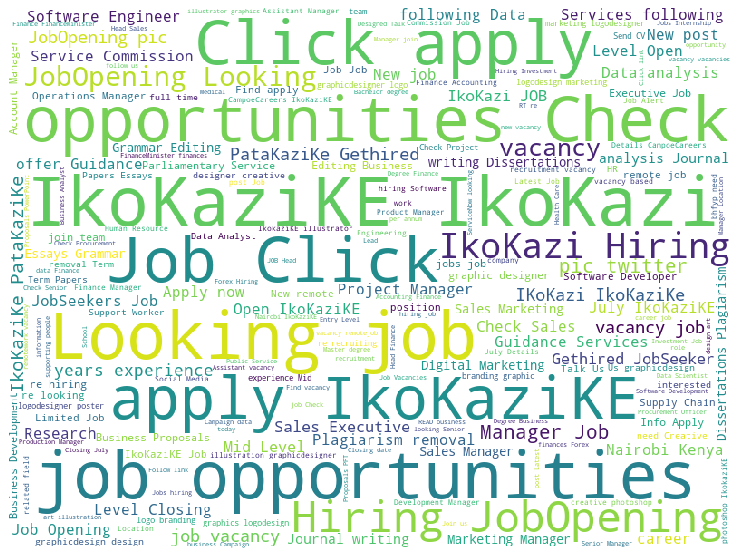

In [30]:
# display the word cloud
cloud(' '.join(twitter_df['clean_tweet']))

### Select the most active tweet sources

In [31]:
active_sources_vc = twitter_df["Source"].value_counts()
active_sources_df = active_sources_vc.rename_axis('source').reset_index(name='counts') # Convert the value count to a dataframe
active_sources_df = active_sources_df[active_sources_df["counts"] > 150]
active_sources_df

,source,counts
0,KaziQuest,972
1,Simon_Ingari,205
2,"Nairobi, Kenya",174
3,Finance_501,159
4,joblify_app,154


In [32]:
list_of_active_tweets = list(active_sources_df["source"])
list_of_active_tweets

['KaziQuest', 'Simon_Ingari', 'Nairobi, Kenya', 'Finance_501', 'joblify_app']

In [33]:
#filter dataframe using list
filtered_twitter_df = twitter_df[twitter_df["Source"].isin(list_of_active_tweets)]
filtered_twitter_df

,Text,Source,industry,clean_tweet,tokens,industry_id
ï»¿Datetime,,,,,,
2020-07-18 13:15:32+00:00,"Evaan Limited is #hiring a Software Tester in Ashford, Surrey #vacancy #jobs",joblify_app,Software Developers,Evaan Limited is hiring a Software Tester in Ashford Surrey vacancy jobs,"[evaan, limited, hiring, software, tester, ashford, surrey, vacancy, jobs]",1
2020-07-08 12:45:40+00:00,"Evaan Limited is #hiring a Software Tester in Ashford, Surrey #vacancy #jobs",joblify_app,Software Developers,Evaan Limited is hiring a Software Tester in Ashford Surrey vacancy jobs,"[evaan, limited, hiring, software, tester, ashford, surrey, vacancy, jobs]",1
2020-07-08 16:51:17+00:00,"Housesimple is #hiring a Software Developer in Colchester, Essex #vacancy #jobs",joblify_app,Software Developers,Housesimple is hiring a Software Developer in Colchester Essex vacancy jobs,"[housesimple, hiring, software, developer, colchester, essex, vacancy, jobs]",1
2020-07-14 08:28:20+00:00,"REMI NETWRORK is #hiring a Software Developers wanted (remote) in Exeter, Devon #vacancy #jobs",joblify_app,Software Developers,REMI NETWRORK is hiring a Software Developers wanted remote in Exeter Devon vacancy jobs,"[remi, netwrork, hiring, software, developers, wanted, remote, exeter, devon, vacancy, jobs]",1
2020-07-12 11:54:54+00:00,"Veiksme Tech Limited is #hiring a Software developer in Ashford, Surrey #vacancy #jobs",joblify_app,Software Developers,Veiksme Tech Limited is hiring a Software developer in Ashford Surrey vacancy jobs,"[veiksme, tech, limited, hiring, software, developer, ashford, surrey, vacancy, jobs]",1
2020-06-20 09:41:50+00:00,"causaLens is #hiring a Data Scientist - Innovative Applications of Causal AI in London, UK #vacancy #jobs",joblify_app,AI Job,causaLens is hiring a Data Scientist Innovative Applications of Causal AI in London UK vacancy jobs,"[causalens, hiring, data, scientist, innovative, applications, causal, ai, london, uk, vacancy, jobs]",4
2020-06-14 13:02:38+00:00,"Oxford Knight is #hiring a Data Scientist- Causality-Focused Fintech in London, UK #vacancy #jobs",joblify_app,AI Job,Oxford Knight is hiring a Data Scientist Causality Focused Fintech in London UK vacancy jobs,"[oxford, knight, hiring, data, scientist, causality, focused, fintech, london, uk, vacancy, jobs]",4
2020-07-07 21:20:59+00:00,"Air X Charter Ltd is #hiring a MRO Finance Executive in London Stansted Airport, Stansted #vacancy #jobs",joblify_app,Finance,Air X Charter Ltd is hiring a MRO Finance Executive in London Stansted Airport Stansted vacancy jobs,"[air, x, charter, ltd, hiring, mro, finance, executive, london, stansted, airport, stansted, vacancy, jobs]",5
2020-07-15 20:10:14+00:00,"JOB | Fundraising Associate | @DalbergTweet | Nairobi, Kenya |Financial Advisory | Masters in Finance, PR, Communications, Economics, Business; 3-5 years experience | Mid Level | Closing 20th July 2020 #IkoKaziKe #IkoKazi",Finance_501,Finance,JOB Fundraising Associate Nairobi Kenya Financial Advisory Masters in Finance PR Communications Economics Business 3 5 years experience Mid Level Closing 20th July 2020 IkoKaziKe IkoKazi,"[job, fundraising, associate, nairobi, kenya, financial, advisory, masters, finance, pr, communications, economics, business, 3, 5, years, experience, mid, level, closing, 20th, july, 2020, ikokazike, ikokazi]",5


In [34]:
filtered_twitter_df.shape

(1664, 6)

In [35]:
stop_words = stopwords.words('english')
stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place','would','really','like','great','service','came','got']) 

In [36]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

In [37]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [38]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [39]:
def bigrams(words, bi_min=6, tri_min=5):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [40]:
list(sent_to_words(filtered_twitter_df.clean_tweet))

[['evaan',
  'limited',
  'is',
  'hiring',
  'software',
  'tester',
  'in',
  'ashford',
  'surrey',
  'vacancy',
  'jobs'],
 ['evaan',
  'limited',
  'is',
  'hiring',
  'software',
  'tester',
  'in',
  'ashford',
  'surrey',
  'vacancy',
  'jobs'],
 ['housesimple',
  'is',
  'hiring',
  'software',
  'developer',
  'in',
  'colchester',
  'essex',
  'vacancy',
  'jobs'],
 ['remi',
  'netwrork',
  'is',
  'hiring',
  'software',
  'developers',
  'wanted',
  'remote',
  'in',
  'exeter',
  'devon',
  'vacancy',
  'jobs'],
 ['veiksme',
  'tech',
  'limited',
  'is',
  'hiring',
  'software',
  'developer',
  'in',
  'ashford',
  'surrey',
  'vacancy',
  'jobs'],
 ['causalens',
  'is',
  'hiring',
  'data',
  'scientist',
  'innovative',
  'applications',
  'of',
  'causal',
  'ai',
  'in',
  'london',
  'uk',
  'vacancy',
  'jobs'],
 ['oxford',
  'knight',
  'is',
  'hiring',
  'data',
  'scientist',
  'causality',
  'focused',
  'fintech',
  'in',
  'london',
  'uk',
  'vacancy',
 

In [73]:
def get_corpus(df):
    df['cleaned_tweet'] = strip_newline(df.clean_tweet)
    words = list(sent_to_words(df.clean_tweet))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    #print(id2word)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    
    return corpus, id2word, bigram

In [74]:
train_corpus, train_id2word, bigram_train = get_corpus(filtered_twitter_df)

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=20,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train.save('./models/lda_train.model')

In [35]:
lda_train.print_topics(20, num_words=15)[:10]

[(0,
  '0.085*"finance" + 0.081*"degree" + 0.055*"accounting" + 0.047*"mid_level" + 0.043*"open" + 0.042*"business" + 0.042*"years_experience" + 0.034*"nairobi_kenya" + 0.028*"related_field" + 0.028*"financial" + 0.026*"entry" + 0.025*"kenya" + 0.024*"bachelor" + 0.022*"administration" + 0.019*"head"'),
 (1,
  '0.253*"head" + 0.151*"sales" + 0.126*"production" + 0.125*"patakazike" + 0.042*"markets" + 0.042*"ict" + 0.041*"wanted" + 0.041*"nanyuki" + 0.039*"animal" + 0.038*"health" + 0.021*"specialist" + 0.019*"vacancy" + 0.000*"researchers" + 0.000*"world" + 0.000*"patakazike_gethired"'),
 (2,
  '0.226*"assistant" + 0.146*"officer" + 0.126*"health" + 0.112*"african" + 0.068*"community" + 0.064*"animal" + 0.061*"investment" + 0.033*"communication" + 0.033*"competition" + 0.027*"senior" + 0.023*"systems" + 0.021*"personal" + 0.019*"kenya" + 0.010*"agricultural" + 0.000*"scientist"'),
 (3,
  '0.310*"patakazike_gethired" + 0.242*"jobseekers_jobs" + 0.124*"vacancy" + 0.057*"internships" + 0.

In [36]:
#df.groupby(['business_id'])['text'].transform('count')
train_vecs = []
for i in range(len(filtered_twitter_df)):
    top_topics = lda_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]        
    #topic_vec.extend([filtered_twitter_df.iloc[i].Source]) # Source can be added once you one-hot-encode the value
    topic_vec.extend([len(filtered_twitter_df.iloc[i].Text)]) # length review
    train_vecs.append(topic_vec)

In [37]:
print(train_vecs[0])

[0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.76249945, 0.012500028, 0.012500028, 0.012500029, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 0.012500028, 76]


In [38]:
X = np.array(train_vecs)
y = np.array(filtered_twitter_df.industry)

In [39]:
X

array([[1.25000281e-02, 1.25000281e-02, 1.25000281e-02, ...,
        1.25000281e-02, 1.25000281e-02, 7.60000000e+01],
       [1.25000281e-02, 1.25000281e-02, 1.25000281e-02, ...,
        1.25000281e-02, 1.25000281e-02, 7.60000000e+01],
       [1.66667067e-02, 1.66667067e-02, 1.66667067e-02, ...,
        1.66667067e-02, 1.66667067e-02, 7.90000000e+01],
       ...,
       [1.24999601e-02, 1.24999601e-02, 1.24999601e-02, ...,
        1.24999601e-02, 1.24999601e-02, 1.40000000e+02],
       [8.33335705e-03, 8.33335705e-03, 4.78697032e-01, ...,
        8.33335705e-03, 8.33335705e-03, 1.51000000e+02],
       [1.25000160e-02, 1.25000160e-02, 1.25000160e-02, ...,
        1.25000160e-02, 1.25000160e-02, 1.31000000e+02]])

In [40]:
y

array(['Software Developers', 'Software Developers',
       'Software Developers', ..., 'Sales Executive Job',
       'Sales Executive Job', 'Sales Executive Job'], dtype=object)

In [41]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # Logistic Regression SGD
    sgd = SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # SGD Modified Huber
    sgd_huber = SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:143

Logistic Regression Val f1: 0.494 +- 0.020
Logisitic Regression SGD Val f1: 0.453 +- 0.051
SVM Huber Val f1: 0.084 +- 0.092


E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Using sklearn

In [42]:
vectors_train, vectors_test, topics_train, topics_test = train_test_split(train_vecs, filtered_twitter_df.industry)

In [43]:
data_train, data_test = train_test_split(filtered_twitter_df, 
                                         test_size=0.10, 
                                         random_state=42)

__GuassianNB Classifier with topic vectors__

In [44]:
# GuassianNB
gnb_classifier = GaussianNB()
gnb_classifier.fit(vectors_train, topics_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
# Predict with the testing set
topics_pred = gnb_classifier.predict(vectors_test)

In [46]:
# ...and measure the accuracy of the results
print(classification_report(topics_test, topics_pred))

                           precision    recall  f1-score   support

                   AI Job       0.17      0.75      0.27         4
          Admin Assistant       0.00      0.00      0.00         0
                Analytics       0.47      0.59      0.52        29
            Communication       0.35      1.00      0.52         6
                Databases       0.11      1.00      0.19         4
                Education       0.12      0.16      0.14        25
                  Finance       0.66      0.63      0.64        30
                   Health       0.33      0.30      0.32        30
          Leave Assistant       0.00      0.00      0.00         0
           Management Job       0.70      0.10      0.17       167
       Personal Assistant       0.00      0.00      0.00         0
              Procurement       0.24      0.89      0.37         9
Public Service Commission       0.28      0.71      0.40        14
      Sales Executive Job       0.56      0.43      0.48     

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


__Support Vector Classifier using topic vectors__

In [47]:
# Initialize the algorithm that you will use by ID
lsvc_classifier = LinearSVC()

In [48]:
# split the dataset by category id
X_train_by_id, X_test_by_id, y_train_by_id, y_test_by_id, indices_train_by_id,indices_test_by_id = train_test_split(
    train_vecs, filtered_twitter_df.industry, filtered_twitter_df.index, 
    test_size=0.33, random_state=12)

In [49]:
# Train the model By Category ID
lsvc_classifier.fit(X_train_by_id, y_train_by_id)

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [50]:
# Make predictions by Category ID
y_pred_lsvc = lsvc_classifier.predict(X_test_by_id)

In [51]:
# View the classification report by ID
print((classification_report(y_test_by_id, y_pred_lsvc)))

                           precision    recall  f1-score   support

                   AI Job       0.00      0.00      0.00         1
          Admin Assistant       0.00      0.00      0.00         5
                Analytics       0.00      0.00      0.00        30
            Communication       0.00      0.00      0.00         7
                Databases       0.00      0.00      0.00         6
                Education       0.06      1.00      0.12        33
                  Finance       0.00      0.00      0.00        48
                   Health       0.00      0.00      0.00        35
          Leave Assistant       0.00      0.00      0.00         2
           Management Job       0.00      0.00      0.00       235
       Personal Assistant       0.00      0.00      0.00         2
              Procurement       0.00      0.00      0.00         6
Public Service Commission       0.00      0.00      0.00        18
      Sales Executive Job       0.62      0.22      0.32     

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
# Checking accuracy by ID
accuracy_score(y_test_by_id, y_pred_lsvc)

0.09636363636363636

In [53]:
# View the confusion matrix BY id
pd.DataFrame(confusion_matrix(y_test_by_id, y_pred_lsvc))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,0
2,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,226,0,0,0,0,0,0,0,9,0,0,0


In [54]:
unique_category_df = filtered_twitter_df[['industry']].drop_duplicates().sort_values('industry')
unique_category_df
#unique_category_to_id = dict(unique_category_df.values)
#unique_category_to_id
#unique_id_to_category = dict(unique_category_df[['encoded_category_id','industry']].values)

,industry
ï»¿Datetime,
2020-06-20 09:41:50+00:00,AI Job
2020-07-17 22:06:51+00:00,Admin Assistant
2020-07-06 04:38:09+00:00,Analytics
2020-07-16 22:01:27+00:00,Communication
2020-07-06 22:00:32+00:00,Databases
2020-06-28 13:54:09+00:00,Education
2020-07-07 21:20:59+00:00,Finance
2020-06-27 05:33:13+00:00,Health
2020-07-17 22:02:37+00:00,Leave Assistant


In [44]:
# Test message
test_message = ["Looking for a machine learning Job"]

In [56]:
def get_bigram(string):
    words = list(sent_to_words(string))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    return bigram

In [49]:
def sent_to_words_(sentences):
    for sentence in sentences:
        unique_var = yield( gensim.utils.simple_preprocess(str(sentence), deacc=True))
        print(unique_var)

In [55]:
bigram_test = gensim.models.Phrases(list(sent_to_words(filtered_twitter_df.clean_tweet)), min_count = 15)
bigram_test

In [ ]:
bigram_mod_test = gensim.models.phrases.Phraser(bigram)

In [57]:
bigram_test = get_bigram(test_message)

In [58]:
bigram_test

[['looking', 'machine', 'learning', 'job']]

In [59]:
test_corpus = [train_id2word.doc2bow(text) for text in bigram_test]

test_vecs = []
for i in range(len(bigram_test)):
    top_topics = lda_train.get_document_topics(test_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    #topic_vec.extend([rev_test.iloc[i].real_counts]) # counts of reviews for restaurant
    topic_vec.extend([len(filtered_twitter_df.Text)]) # length review
    test_vecs.append(topic_vec)

In [60]:
test_vecs

[[0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.52499884,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  0.025000058,
  1664]]

In [61]:
# Make the prediction
predicted_category_id = lsvc_classifier.predict(test_vecs)

In [62]:
predicted_category_id[0]

'Education'

### Using Logistic Regression

In [63]:
#vectors_train, vectors_test, topics_train, topics_test = train_test_split(train_vecs, filtered_twitter_df.industry)
sentences = filtered_twitter_df['clean_tweet'].values
y = filtered_twitter_df['industry'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [64]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [65]:
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<1248x1260 sparse matrix of type '<class 'numpy.int64'>'
	with 23941 stored elements in Compressed Sparse Row format>

In [66]:
lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, y_train)
lg_score = lg_classifier.score(X_test, y_test)
print("Accuracy:", lg_score)

E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.9903846153846154


### Using CNN

In [67]:
# vocabulary
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]

In [68]:
all_training_words

['looking',
 'job',
 'opportunities',
 'check',
 'cook',
 'lecturer',
 'kenya',
 'red',
 'cross',
 'society',
 'job',
 'click',
 'apply',
 'ikokazike',
 'ikokazi',
 'hiring',
 'jobopening',
 'chisel',
 'ai',
 'hiring',
 'software',
 'developer',
 'toronto',
 'ontario',
 'vacancy',
 'jobs',
 'looking',
 'job',
 'opportunities',
 'check',
 'project',
 'manager',
 'job',
 'click',
 'apply',
 'ikokazike',
 'ikokazi',
 'hiring',
 'jobopening',
 'looking',
 'job',
 'opportunities',
 'check',
 'software',
 'developer',
 'job',
 'click',
 'apply',
 'ikokazike',
 'ikokazi',
 'hiring',
 'jobopening',
 'looking',
 'job',
 'opportunities',
 'check',
 'senior',
 'account',
 'manager',
 'job',
 'click',
 'apply',
 'ikokazike',
 'ikokazi',
 'hiring',
 'jobopening',
 'job',
 'head',
 'operational',
 'risk',
 'nairobi',
 'ke',
 'commercial',
 'banking',
 'degree',
 'business',
 'related',
 'field',
 'economics',
 'finance',
 'accounting',
 'aprm',
 'cra',
 'prm',
 'frm',
 'mid',
 'level',
 'closing',
 

In [69]:
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

22811 words total, with a vocabulary size of 1355
Max sentence length is 31


In [70]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

2494 words total, with a vocabulary size of 495
Max sentence length is 31


In [71]:
# use pre-trained word-embeddings
word2vec_path = './embeddings/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [72]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [73]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [74]:
# get the embeddings
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [76]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [75]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["clean_tweet"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["clean_tweet"].tolist())

In [78]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 1400 unique tokens.


In [79]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [80]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(1401, 300)


In [81]:
test_sequences = tokenizer.texts_to_sequences(data_test["clean_tweet"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

__Defining the CNN__

In [82]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [97]:
label_names = list(unique_category_df.industry.values)
len(label_names)

17

In [92]:
y_train = data_train["industry"].values
y_train

array(['Education', 'Software Developers', 'Management Job', ...,
       'Management Job', 'Sales Executive Job', 'Management Job'],
      dtype=object)

In [95]:
len(data_train["industry"].values)

1497

In [ ]:
x_train = train_cnn_data
y_tr = y_train

In [99]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,len(list(label_names)))

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

__Helper Notebook References__

1. https://github.com/marcmuon/nlp_yelp_review_unsupervised/blob/master/notebooks/2.0_optional_HDP_Model_to_find_number_of_topics_for_LDA.ipynb![image.png](attachment:image.png)
2. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28![image.png](attachment:image.png)
3. https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb![image.png](attachment:image.png)
4. https://radimrehurek.com/gensim/models/phrases.html
5. https://www.kite.com/python/docs/gensim.models.phrases